# Discrete sampling
In the last problem of the first session we sampled with given probabilities using prefix sums and binary search. The sampling code is the bottleneck of the whole process, its running times is 3 times higher than the code for uniform probabilities, and the difference would only increase for larger number of outcomes. In the next two problems we discuss two simple, but powerful techniques one can use to sample in time $O(1)$.

**Problem 2a.** Consider the problem of sampling with known probabilities $p_1,\ldots,p_d$. Suppose that you have a black-box that samples with probabilities $q_1,\ldots,q_d$ that are close to $p_1,\ldots,p_d$, say
$$ \forall_{i=1,\ldots,n} p_i \le (1+\varepsilon)q_i.$$

* How can you use this black-box to sample with probabilities $p_1,\ldots,p_d$? It is expected, that the running time of the algorithm would be non-deterministic.
* Prove that your algorithm is correct.
* Implement the algorithm and use it to give a faster implementation for **Problem 1c**.

**Problem 2b.** One of the reasons this implementation is not significantly faster than the one in **Problem 1c** , apart from $d$ being rather small, is that we are using Python's interpreter a bit too much, and Python is slow. One way around this is usually to use a library function - **searchsorted** is much faster than an equivalent code implemented in pure Python. But even if the functionality you need is not implemented in a lower level language as
a library function, there is still hope. You can try to implement it using optimized array algebra, for example using **numpy**. In this problem, your task is to rewrite the previous algorithm, so that the amount of *looping* is reduced to a minimum necessary. In particular, you should create a *vectorized* version of random dates generation (in bulk), while the actual search for duplicates remains a loop with a **set**. Here are some useful tips:
   * You can perform arithmetic, comparisons, etc. on **numpy** arrays.
   * You can generate whole **numpy** arrays of random numbers at once.
   * You can even perform parallel look-up like in the example below.

In [20]:
X = np.array([10,3,7])
I = np.array([1,1,2,2])
print(X[I])
X = np.array([[1,2],[3,4]])
I = np.array([0,0,1])
J = np.array([1,0,1])
print(X[I,J])

[3 3 7 7]
[2 1 4]


**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.

During histogram squaring, when we transfer frequencies from one bucket to another, we do not change the mean which is M = 1/n. We take one bucket which has volume less than M, then we definitely know that there is another bucket that has volume bigger than M, as otherwise the mean would be smaller than M which is contradiction. We take the desired volume to fill the bucket with less volume up to M and then we will not touch it, but we mark it as it has some volume from a bucket that has bigger volume than M.
If we do not find any bucket with volume less than M then it means that all buckets have volume equal to M as otherwise the mean will be bigger than M if one of the buckets has bigger volume than M. So, al the volumes are equal to M.
After the operations, each bucket will contain at most two $p_i$ where one is the original and the other is the giver or donor that filled untill mean M. It is possible that the bucket had volume equal to mean M or bigger than M and it was giver or donor for the other buckets.

In [94]:
import numpy as np

# No. of samples to generate is set to be 5.
p = np.linspace(0, 1, num=5)

def squaring_histogram(p):
    # Bucket: Type used is float.
    B = np.array(p, dtype='f')
    N = B.size
  
    mean = np.mean(B)
    
    Giver = np.arange(N)
    Probs = np.empty(N)
    Probs.fill(mean)
    
    while np.count_nonzero(B < mean):

        i = np.where(B < mean)[0][0]
        j = np.where(B > mean)[0][0]

        Giver[i] = j
        Probs[i] = B[i]
        
        B[j] = B[j] - (mean - B[i])
        B[i] = mean
        
    return Giver, Probs

In [96]:
# Trying to find repetitions with set as comparing with vector shows set is faster.
def find_repetitions_set(a):
    s = set()
    n = 0
    for v in a:
        n += 1
        
        if v in s:
            return n
        else:
#           Updates the set with v.
            s |= {v} 
    return n

In [95]:
import pandas as pd
# Getting data and squaring.

data = pd.read_csv('us_births_69_88.csv')
births = np.array(data['births'])

# Squaring time can be calculated.
# timeit.timer squaring_histogram(births)

In [97]:
n = births.size
mean = np.mean(births)
# K is the number of samples to be generated.
K = 77

sample_days = np.random.randint(0, n-1, K)
sample_births = np.random.random_sample(K) * mean

Donor, Probs = squaring_histogram(births)

days = []
for i in range(K):
    day = sample_days[i]
    day_prob = sample_births[i]
    
    if day_prob < Probs[day]:
        days.append(day)
    else:
        days.append(Donor[day])

# Vectorizing.
use_original_value = sample_births < Probs[sample_days]
# ~ is bitwise NOT in python.
use_donor_value = ~use_original_value
sample_days[use_donor_value] = Donor[sample_days[use_donor_value]]

# Finds the repetitions.
find_repetitions_set(sample_days)

3

#Samples = 100000 - runtime: 1.1459221839904785s


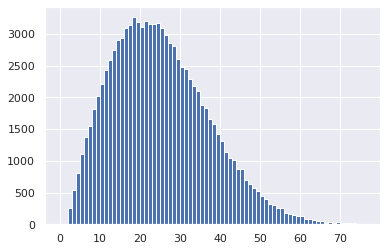

In [104]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import time
%matplotlib inline

# Repetitions
samples = 10**5
K = 77

Donor, Probs = squaring_histogram(births)

# Start of alg
# start = time.time()

sample_days = np.random.randint(0, n-1, (samples, K))
sample_births = np.random.random_sample((samples,K)) * mean

use_original_value = sample_births < Probs[sample_days]
use_donor_value = ~use_original_value

sample_days[use_donor_value] = Donor[sample_days[use_donor_value]]

result = np.apply_along_axis(find_repetitions_set, 1, sample_days)

# End of alg
# end = time.time()

plt.hist(result, np.arange(K))
# To show plots in non-interactive modes.
# plt.show(block=True)
# To show how fast the algorithm works. Note it is about time before plotting.
print("#Samples = {} - runtime: {}s".format(samples, end-start))


**Problem 2d.** Show that the frequency histogram for empirical birthday frequencies can actually be computed exactly, and implement your idea. To this end, design a recurence relation using conditional probabilities and use dynamic programming.

**BONUS**. An alternative plotting library: plotly

In [19]:
#install plotly with: pip install plotly
#you can run this shell command directly from Jupyter, by prefixing it with !
!pip install plotly

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import numpy as np

init_notebook_mode(connected=True)

# example scatterplot

x = np.linspace(0, 1, 10)
y = x * x

iplot([go.Scatter(x=x, y=y, name="y=x^2"), go.Scatter(x=x, y=-y, name="y=-x^2")])

# example heatmap

iplot([go.Heatmap(z=[[10, 20, 30, 40],
                      [20, 30, 40, 50],
                      [30, 40, 50, 60]])])


/usr/bin/sh: pip: command not found
